In [1]:
''' O projeto se divide em análise de timesires e uma tentativa de prever evazão
fazendo uso de um algoritmo supervisionado
----Passos Time series
1 - Baixar o Log no moodle de eventos no moodle para atividades de participação -
OK
2 - Filtrar os usuário que não são alunos - Excel -pré processamento
OK
3 - Fazer discretização(IP) - Coluna Rede_Puc
OK
4 - Adicionar uma coluna referente ao cronograma(unidade 1 e etc)
Ok
5 - Adicionar coluna com as turmas
OK
6-  Plotar gráficos com a visualização
OK
------
------ Passos Forecasting
1 - Converter a tabela de time series em um data set anterior em um transicional
    1.1 - Plotar gráfico com estatśticas gerais de uso
    1.2 - Talvez clusterizar os alunos
2 - Descobrir quais usuários trancaram a disciplina - Log de atividades CLI
3 - Descobrir se existe uma data com pico de trancamento
4 - Baseado na relação entre data e trancamento definir um intervalo e filtrar o dataset antes desse pico.
Fazendo isso imagino que posso descobrir algum padrão nos usuários que trancam. Esse será meu target Y
5 - Rodar um random forest
6 - avaliar desempenho
'''
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from datetime import datetime        
%matplotlib inline
sns.set()

In [2]:
#time series att
def rede_puc(turmas):
    ip = '139.82'
    rede = []
    for x in turmas.IP:
        if(ip == x[0:6]):
            rede.append('S')
        else:
            rede.append('N')
    turmas.insert(1, column='Rede_Puc', value=rede)#Passo 5
    return turmas

In [3]:
def obter_turmas():
    df_ = pd.DataFrame()
    frames = [df_]
    
    for dados_turma in glob.glob('dados/turmas/*'):
        grupo = dados_turma[13:-4]# obtem código do grupo
        df = pd.read_csv(dados_turma)#lê arquivo
        df.insert(3, column='Turma', value=grupo)#insere coluna
        print(df.shape)
        frames.append(df)
    dados = pd.concat(frames)
    dados.columns = [c.replace(' ', '_') for c in dados.columns]#Troca espaço por underline no cabeçalho
    dados.drop_duplicates(keep=False, inplace=True)#limpando dados duplicados
    dados['Data'], dados['Hora'] = dados['Hora'].str.split(' ', 1).str#divide a coluna Hora em duas colunas
    dados.Data = pd.to_datetime(dados.Data,dayfirst=True)
    
    return dados



In [4]:
#time series att
def obter_unidades(t): 
    unidades= []
    data_unidades = {
        'IU1':datetime(2018, 3, 19),
        'FU1':datetime(2018, 4, 18),
        'IU2':datetime(2018, 4, 18),
        'FU2':datetime(2018, 5, 9),
        'IU3':datetime(2018, 5, 9),
        'FU3':datetime(2018, 5, 23),
        'IU4':datetime(2018, 5, 23),
        'FU4':datetime(2018, 6, 27)
    }

    for x in t.Data:
        if(data_unidades['IU1'] <= x < data_unidades['FU1']):
            unidades.append('unidade_1')
        elif(data_unidades['IU2'] <= x < data_unidades['FU2']):
            unidades.append('unidade_2')
        elif(data_unidades['IU3'] <= x < data_unidades['FU3']):
            unidades.append('unidade_3')
        elif(data_unidades['IU4'] <= x < data_unidades['FU4']):
            unidades.append('unidade_4')
        else:
            unidades.append('fora_de_epoca')
            
        
    t.insert(1, column='Unidade', value=unidades)
    return t

   

In [5]:
def obter_periodo_dia(t):
    periodo = {
        'P1I':'00:00',
        'P1F':'04:00',
        'P2I':'04:00',
        'P2F':'08:00',
        'P3I':'08:00',
        'P3F':'12:00',
        'P4I':'12:00',
        'P4F':'16:00',
        'P5I':'16:00',
        'P5F':'20:00',
        'P6I':'20:00',
        'P6F':'24:00'
    }
    periodo_list = []
    for x in t.Hora:
        if (periodo['P1I'] <= x < periodo['P1F']):
            periodo_list.append('1')
        elif(periodo['P2I'] <= x < periodo['P2F']):
            periodo_list.append('2')
        elif(periodo['P3I'] <= x < periodo['P3F']):
            periodo_list.append('3')
        elif(periodo['P4I'] <= x < periodo['P4F']):
            periodo_list.append('4')
        elif(periodo['P5I'] <= x < periodo['P5F']):
            periodo_list.append('5')
        elif(periodo['P6I'] <= x < periodo['P6F']):
            periodo_list.append('6')

        
    t.insert(1, column='Periodo', value=periodo_list)
    return t

    

In [6]:
turmas = obter_turmas() 
turmas = rede_puc(turmas)
turmas = obter_unidades(turmas)
turmas = obter_periodo_dia(turmas)


(19175, 7)
(19491, 7)


In [ ]:
turmas.to_csv('turmas.csv')

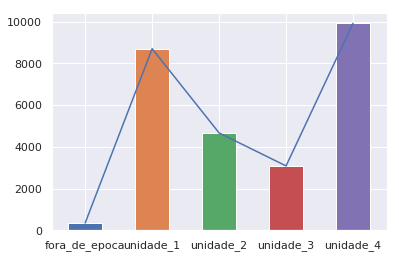

In [7]:

turmas['Unidade'].value_counts().sort_index().plot.bar();
turmas['Unidade'].value_counts().sort_index().plot.line();

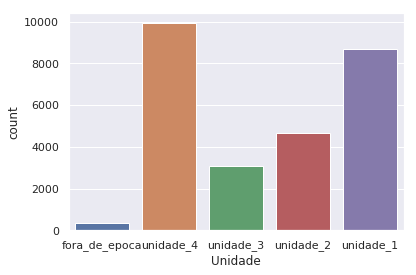

In [9]:
sns.countplot(turmas['Unidade']);

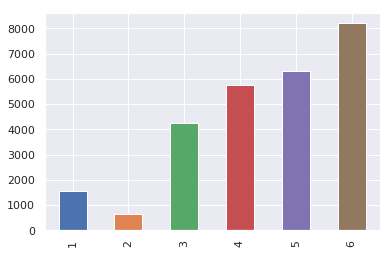

In [10]:
turmas['Periodo'].value_counts().sort_index().plot.bar();

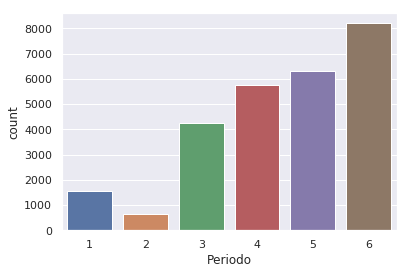

In [11]:
sns.countplot(x=turmas['Periodo'],data=turmas);

Curso: CRE1100 - O HUMANO E O FENOM RELIGIOSO - 2018.1                                                               5435
Fórum: Fórum IV - O fenômeno religioso: interpretações e grandes tradições religiosas                                3191
Fórum: Fórum I - Experiência religiosa e as religiões no mundo contemporâneo                                         2600
Fórum: Fórum II - Quem somos nós? Refletindo sobre a pessoa humana, essa buscadora de sentido                        1539
Fórum: Fórum III - Deus e a religião em questão: visões críticas                                                     1284
Livro: 6. Dimensões fundamentais da pessoa humana: interioridade e abertura                                          1077
Livro: 10. Categorias de interpretação do fenômeno religioso                                                         1035
Livro: 9. Principais críticos da religião e da existência de Deus: L. Feuerbach, K. Marx, F. Nietzsche e S. Freud     923
Livro: 2. A diversidade 

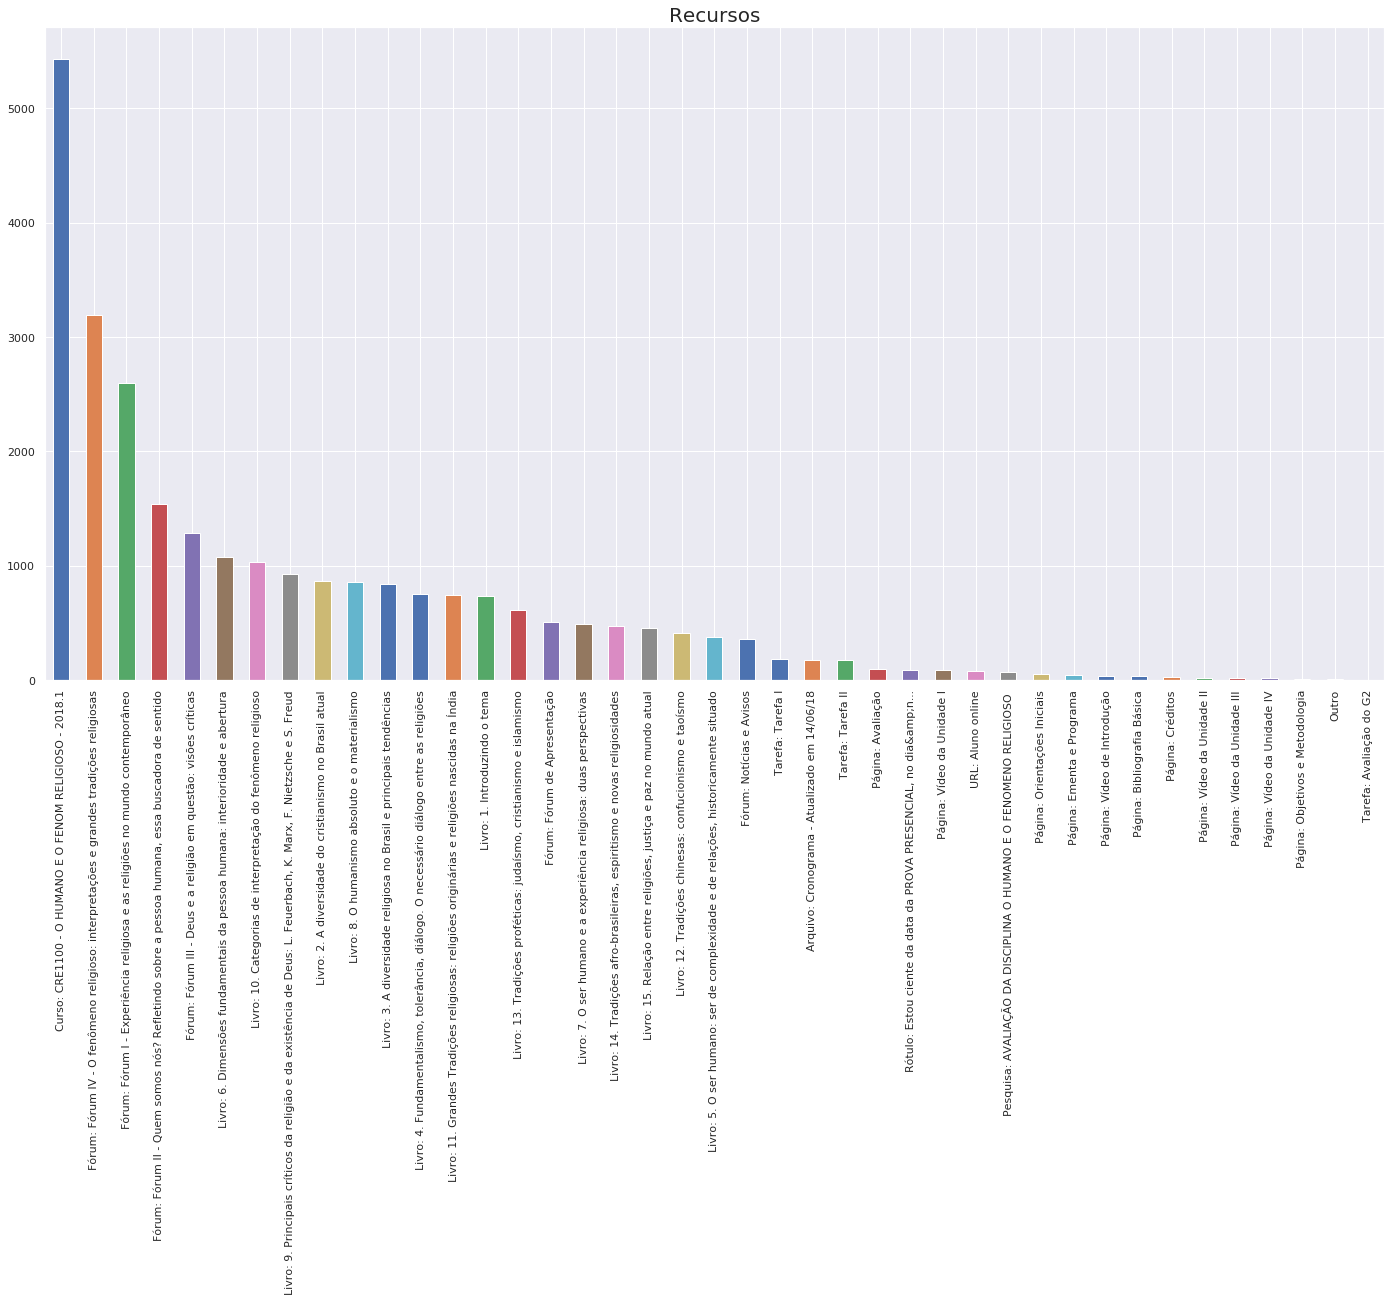

In [12]:
recursos = turmas['Contexto_do_Evento'].value_counts().plot.bar(figsize=(24, 12))
recursos.set_title("Recursos", fontsize=20)
turmas['Contexto_do_Evento'].value_counts()


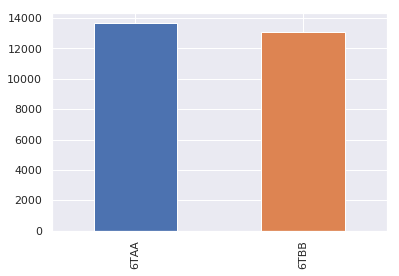

In [13]:
turmas['Turma'].value_counts().sort_index().plot.bar();


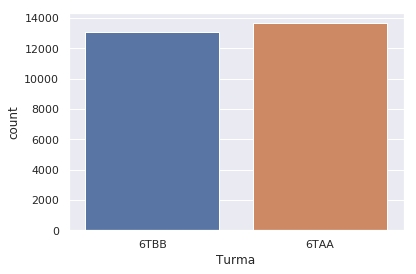

In [14]:
sns.countplot(x=turmas['Turma'],data=turmas);

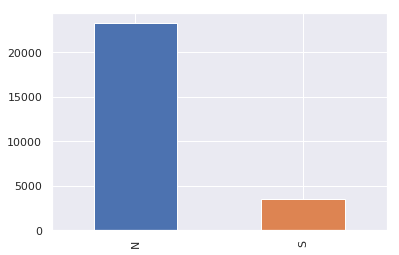

In [15]:
turmas['Rede_Puc'].value_counts().sort_index().plot.bar();


In [18]:
#Parte 2
turmas2=turmas.groupby('Nome_completo')['Contexto_do_Evento'].value_counts().sort_index().unstack().fillna(0)#tranformando timesires em data frame
